参考：https://github.com/aishoot/Sound_Localization_Algorithms/tree/master/MUSIC-DOA-Estimation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

# MUSIC

In [2]:
N = 3
M = 10
p = 100
fc = 1e6
fs = 1e7
np.random.seed(0)

信号源の生成

* 信号源は複素数
* $N \times p$ の複素数行列 `s` を生成
* 各信号はランダムな振幅 `amp` を持つ
  * `np.random.multivariate_normal` 関数は、多変量正規分布からサンプルを生成するための関数
  * `mean`：平均ベクトル、平均値は 0
  * `cov`：共分散行列、単位行列 `np.diag(np.ones(N))`
* キャリア周波数 fc の正弦波としてモデル化
  * オイラーの公式 $e^{jx} = \cos(x) + j \sin(x)$ より、複素数を使って正弦波を表現
  * この中の `x`: 角度 を `t_val` をすこしずつ進めることで回している
  * そこに `amp` をかけることで、振幅を変えている

In [3]:
s = np.zeros((N, p), dtype=complex)  # 複素数型で初期化
for t in range(p):
    t_val = t / fs  # 時間の値を計算
    amp = np.random.multivariate_normal(mean=np.zeros(N), cov=np.diag(np.ones(N)))  # 振幅をランダムに生成
    s[:, t] = np.exp(1j * 2 * np.pi * fc * t_val) * amp
print(f"{s.shape=}")

s.shape=(3, 100)


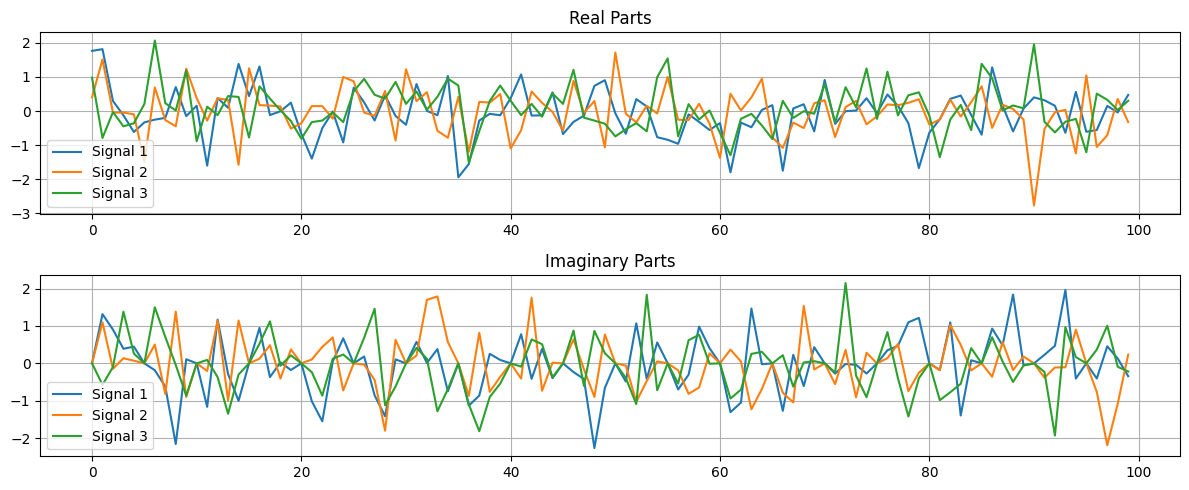

In [4]:
plt.figure(figsize=(12, 5))

plt.subplot(2, 1, 1)
for i in range(N):
    plt.plot(s[i, :].real, label=f"Signal {i+1}")
plt.title("Real Parts")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
for i in range(N):
    plt.plot(s[i, :].imag, label=f"Signal {i+1}")
plt.title("Imaginary Parts")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

受信信号の取得：遅延の影響（ステアリング行列を使用）とノイズの混入後

ここでは、信号源からの信号が受信アンテナに到達するまでの遅延の影響を考慮し、ノイズと混合した結果の信号を取得します。

信号源からの信号の方向到達（DOA）はそれぞれ 20度、50度、85度、110度、145度 と仮定します。これらの値は MUSIC アルゴリズムを使用して求めます。

信号が光速 $c = 3 \times 10^8 m/s$ で伝播すると仮定します。

受信アンテナは直線上に配置され、隣接するアンテナ間の間隔は 150m とします。

In [5]:
# DOAs (Direction of Arrivals) in radians
doas = np.array([50, 85, 145]) * np.pi / 180

speed_of_light = 3e8
antenna_spacing = 150

# Steering Vector as a function of angle theta
def compute_steering_vector(theta):
    steering_vector = np.exp(-1j * 2 * np.pi * fc * antenna_spacing * (np.cos(theta) / speed_of_light) * np.arange(M))
    return steering_vector.reshape((M, 1))

# Steering matrix
A = np.zeros((M, N), dtype=complex)
for i in range(N):
    A[:, i] = compute_steering_vector(doas[i])[:, 0]

print(f"Shape of steering matrix: {A.shape}")

Shape of steering matrix: (10, 3)


受信信号 $x(t)$ は、以下のようにモデル化される：

$$x(t) = A(\theta) \cdot s(t) + n(t)$$

ここで、$n(t)$ は各受信機における白色ガウスノイズを表す

In [6]:
n = np.random.multivariate_normal(mean=np.zeros(M), cov=np.diag(np.ones(M)), size=p).T
X = A @ s + n
print(f"{X.shape=}")

X.shape=(10, 100)


MUSICアルゴリズムの適用：

受信信号データ `X`、信号源の周波数 `fc`、信号源の数 `M` が既知の場合、MUSIC アルゴリズムを使用して、各信号源の到達方向（DOA）を推定

* 相関行列 `R` を計算する
  * conj は複素共役
  * エルミート転置をするために、複素共役を撮った後に転置
  * サンプル数 `p` で割って正規化
* 信号源とノイズの部分空間を分けるためには、固有値が大きいものを選択すればよいので、固有値の大きい順に並べ替える
* $Av = \lambda v$ の性質が成り立っていることを確認
  * 固有ベクトルと固有値の計算が正しく行われていることを確認できる

In [7]:
# Compute covariance matrix of X
Rxx = X @ X.conj().T / p

# Compute eigen values and eigen vectors
eigvals, eigvecs = np.linalg.eig(Rxx)  # 固有値と固有ベクトル
eigvals = eigvals.real
eignorms = np.abs(eigvals)

# Sort eigvals and eigvecs in decreasing order of eigvals
idx = eignorms.argsort()[::-1]
eignorms = eignorms[idx]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

print("eigvals=", eigvals)

eigvals= [13.10696888 10.78370862  8.69654158  1.2815281   1.16654379  1.05839406
  0.89819457  0.82439073  0.65913796  0.50872679]


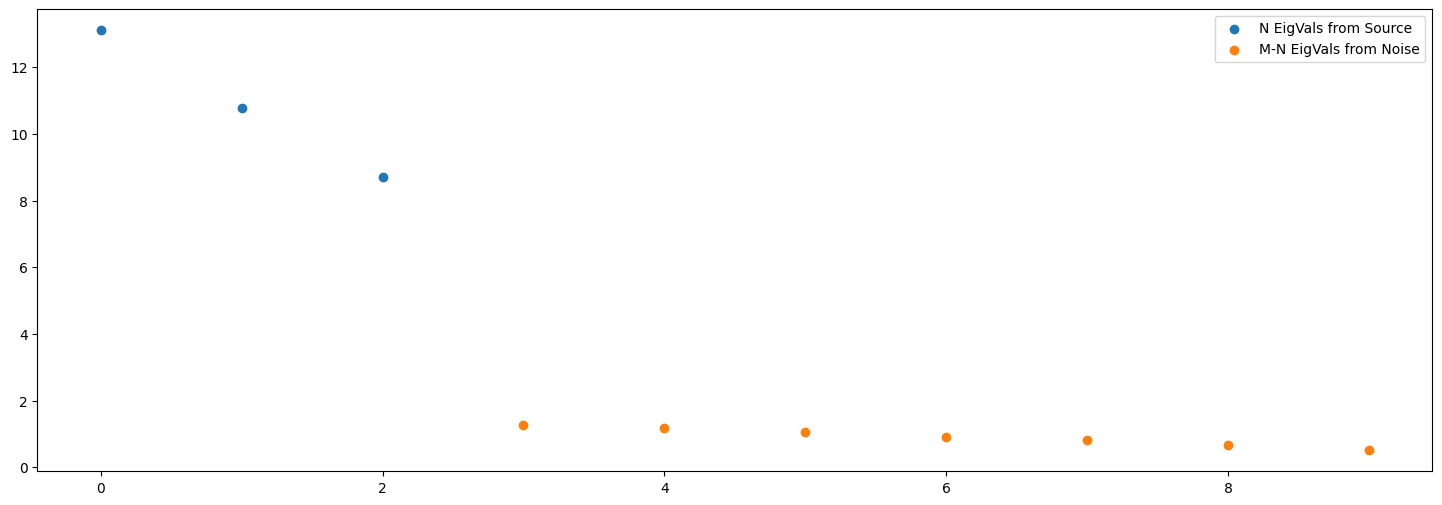

In [8]:
# Plotting Eigen Values
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter(np.arange(N), eigvals[:N], label="N EigVals from Source")
ax.scatter(np.arange(N,M), eigvals[N:], label="M-N EigVals from Noise")
plt.legend()

ノイズによる下位M-Nの固有値がほぼ等しい（= lb0）こと、および上位Nの固有値lbiがlb0より大きいことを確認

In [9]:
# separating source and noise eigvectors
signal_eigvecs, noise_eigvecs = eigvecs[:, :N], eigvecs[:, N:]
print(signal_eigvecs.shape)
print(noise_eigvecs.shape)

(10, 3)
(10, 7)


MUSIC スペクトルを計算

$$P(\theta) = \frac{{\mathbf{v}^H(\theta) \mathbf{v}(\theta)}}{{\| \mathbf{v}^H(\theta) \mathbf{E} \|^2}} = \frac{{\mathbf{v}^H(\theta) \mathbf{v}(\theta)}}{{\mathbf{v}^H(\theta) \mathbf{E} \mathbf{E}^H \mathbf{v}(\theta)}}$$

* $\mathbf{v}(\theta)$ はステアリングベクトル (steering vector)
* $\mathbf{E}$ はノイズ部分空間を表す固有ベクトル (eigen vectors representing the noise subspace)

In [10]:
def compute_music_spectrum(theta):
    steering_vector = compute_steering_vector(theta)
    vector_norm_squared = np.abs(steering_vector.conj().T @ steering_vector)[0,0]
    noise_projection = steering_vector.conj().T @ noise_eigvecs @ noise_eigvecs.conj().T @ steering_vector
    return vector_norm_squared / noise_projection[0, 0]

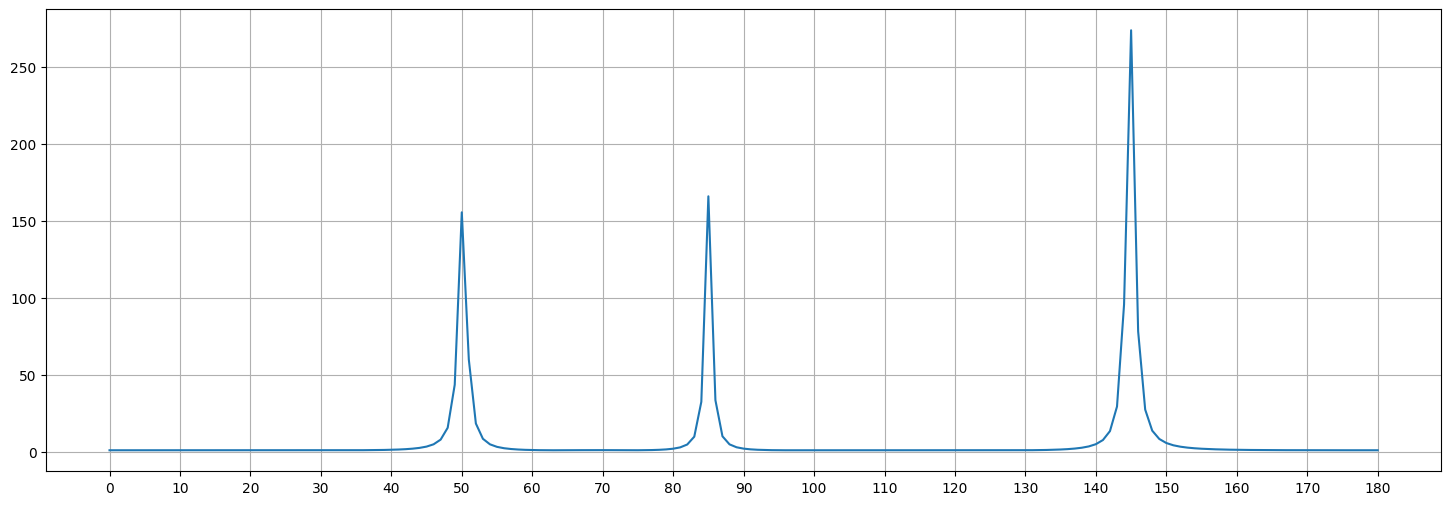

In [11]:
# Search for all possible theta
theta_vals = np.arange(0, 181, 1)
music_spectrum_vals = np.array([compute_music_spectrum(val * np.pi / 180.0) for val in theta_vals]).real

fig, ax = plt.subplots(figsize=(18, 6))
plt.plot(np.abs(theta_vals), music_spectrum_vals)
plt.xticks(np.arange(0, 181, 10))
plt.grid()

In [12]:
# parameters for peak finding
height = np.max(music_spectrum_vals) * 0.1  # peaks are at least 10% of max
distance = 10  # peaks are at least 10 degrees apart

peak_indices, _ = scipy.signal.find_peaks(music_spectrum_vals, height=height, distance=distance)
print(theta_vals[peak_indices])

[ 50  85 145]


# GEVD-MUSIC

In [13]:
# Noise DOAs (Direction of Arrivals) in radians
noise_doas = np.array([20, 110]) * np.pi / 180

# Noise matrix
N_noise = len(noise_doas)
s_noise = np.zeros((N_noise, p), dtype=complex)  # Initialize as complex numbers
for t in range(p):
    t_val = t / fs  # Calculate the value of time
    amp = np.random.multivariate_normal(mean=np.zeros(N_noise), cov=np.diag(np.ones(N_noise)))  # Generate amplitude randomly
    s_noise[:, t] = np.exp(1j * 2 * np.pi * fc * t_val) * amp

print(f"{s_noise.shape=}")

s_noise.shape=(2, 100)


In [14]:
# Steering matrix for noise
A_noise = np.zeros((M, N_noise), dtype=complex)
for i in range(N_noise):
    A_noise[:, i] = compute_steering_vector(noise_doas[i])[:, 0]

# Generate the received noise signal
n = np.random.multivariate_normal(mean=np.zeros(M), cov=np.diag(np.ones(M)), size=p).T
X_noise = A_noise @ s_noise + n

# Compute the noise correlation matrix
Rnn = X_noise @ X_noise.conj().T / p

In [15]:
# Generate the received signal with noise and source signals
X_total = X + X_noise  # shape: (10, 100)
# Compute covariance matrix of X_total
Rxx_total = X_total @ X_total.conj().T / p

単に MUSIC をかけるとノイズの影響を受ける

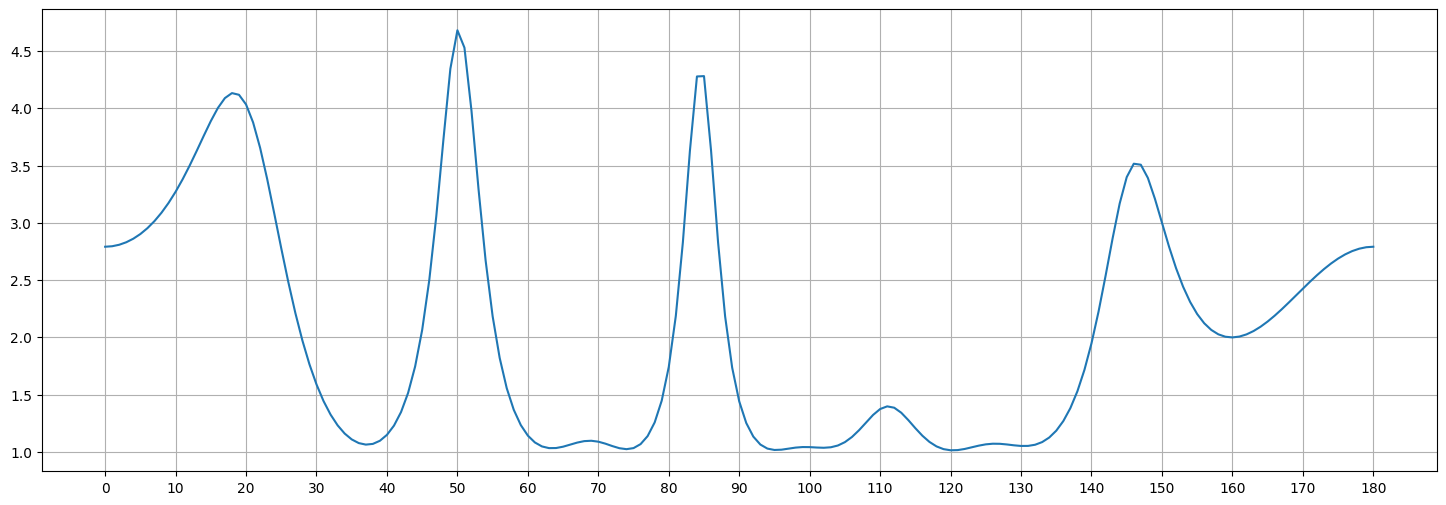

In [16]:
eigvals, eigvecs = np.linalg.eig(Rxx_total)

idx = eigvals.argsort()[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]

# Separate source and noise eigvectors
signal_eigvecs, noise_eigvecs = eigvecs[:, :N], eigvecs[:, N:]

# Compute the MUSIC spectrum and find the peaks as before
music_spectrum_vals = np.array([compute_music_spectrum(val * np.pi / 180.0) for val in theta_vals]).real

fig, ax = plt.subplots(figsize=(18, 6))
plt.plot(np.abs(theta_vals), music_spectrum_vals)
plt.xticks(np.arange(0, 181, 10))
plt.grid()

GEVD だとノイズを抑制できる

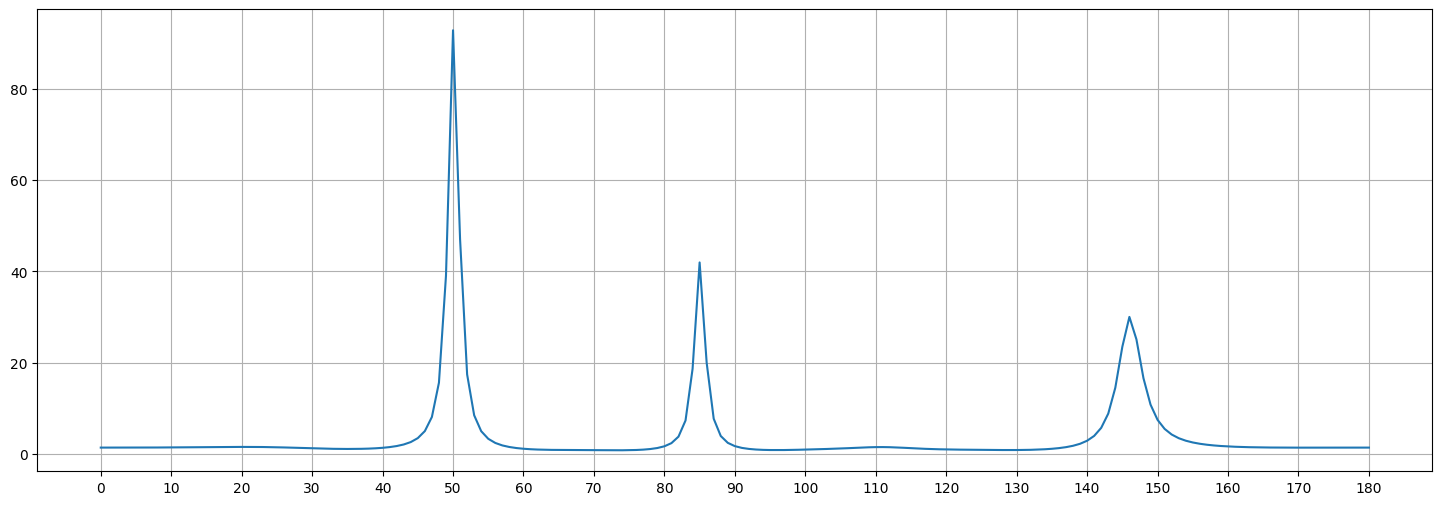

In [17]:
# Perform GEVD
eigvals, eigvecs = scipy.linalg.eig(Rxx_total, Rnn)

# Sort in decreasing order of eigenvalues
idx = eigvals.argsort()[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]

# Separate source and noise eigvectors
signal_eigvecs, noise_eigvecs = eigvecs[:, :N], eigvecs[:, N:]

# Compute the MUSIC spectrum and find the peaks as before
music_spectrum_vals = np.array([compute_music_spectrum(val * np.pi / 180.0) for val in theta_vals]).real

fig, ax = plt.subplots(figsize=(18, 6))
plt.plot(np.abs(theta_vals), music_spectrum_vals)
plt.xticks(np.arange(0, 181, 10))
plt.grid()